In [2]:
import pandas as pd
import numpy as np
from math import radians, degrees, sin, cos, asin, acos, sqrt
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle

In [3]:
# function to calculate great Circle distance : 
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )

In [4]:
# Read Co-ordinate Data
data=pd.read_csv("coor.csv")
data.head()

,id,xcoord,ycoord
0,1,-122.30233,47.69658
1,2,-122.34486,47.71863
2,3,-122.29402,47.73222
3,4,-122.40249,47.69010
4,5,-122.30656,47.70418


In [5]:
arr=np.array([data['xcoord'],data['ycoord']])
arr=np.transpose(arr)

In [6]:
lon1=arr[0][0]
lat1=arr[0][1]
lon2=arr[1][0]
lat2=arr[1][1]
print(lon1, lat1, lon2, lat2)

-122.30233 47.69658 -122.34486000000001 47.71863


In [7]:
N=len(data)
D = np.zeros(shape=(N,N), dtype=float)
for i in range(N):
    for j in range(i+1,N):
        lon1=arr[i][0]
        lat1=arr[i][1]
        lon2=arr[j][0]
        lat2=arr[j][1]
        D[i][j]=great_circle(lon1, lat1, lon2, lat2)
        D[j][i]=D[i][j]

In [8]:
#Creating a Distance Matrix
distanceMatrix=pd.DataFrame(D)
distanceMatrix.to_csv("DistanceMatrix_2.csv")

In [9]:
distanceMatrix=pd.read_csv("DistanceMatrix_2.csv")

In [10]:
#Reading Candidate Facility File
facility=pd.read_csv("fac.csv")
facArr=np.array([facility['xcoord'],facility['ycoord']])
facArr=np.transpose(facility)
facArr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
xcoord,-122.353,-122.310,-122.273,-122.376,-122.396,-122.333,-122.298,-122.335,-122.366,-122.398,-122.293,-122.379,-122.292,-122.380,-122.303
ycoord,47.536,47.537,47.541,47.549,47.575,47.578,47.587,47.614,47.639,47.650,47.661,47.668,47.683,47.686,47.716


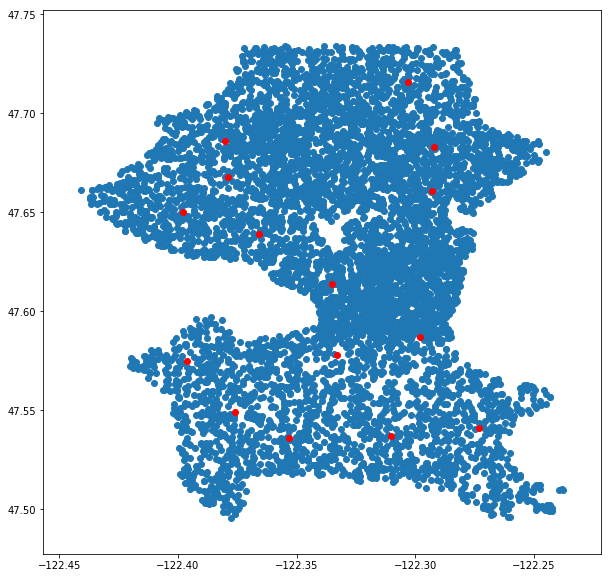

In [11]:
df = data.sort_values(by=['xcoord', 'ycoord'])
plt.figure(figsize=(10,10))
plt.scatter(df['xcoord'],df['ycoord'])
plt.scatter(facility['xcoord'],facility['ycoord'], color='r')
plt.savefig("Candidate_Facilities.png")

#ax = df.plot(kind='scatter', x='xcoord', y='ycoord', alpha=0.5, linewidth=0)

In [12]:
N=len(data)
F=len(facility)
facD = np.zeros(shape=(F,N), dtype=float)

In [13]:
#Creating a Distance Matrix Between 15 Facility locations and 7000 Customers
for i in range(F):
    for j in range(N):
        lon1=facArr[i][0]
        lat1=facArr[i][1]
        lon2=arr[j][0]
        lat2=arr[j][1]
        facD[i][j]=great_circle(lon1, lat1, lon2, lat2)        

In [14]:
facD

array([[18.25514007, 20.31668929, 22.26174085, ...,  7.03781274,
         5.86662716,  4.00387647],
       [17.7537971 , 20.36458744, 21.74047151, ...,  3.98784286,
         4.69561264,  2.46819903],
       [17.43882322, 20.47244911, 21.32094334, ...,  2.23327623,
         5.0004504 ,  3.56396638],
       ...,
       [ 1.69647415,  5.59860562,  5.47510095, ..., 17.99345408,
        11.60412058, 13.85396963],
       [ 5.93129137,  4.48099489,  8.23409247, ..., 20.23765876,
        13.03833291, 14.99397547],
       [ 2.15998736,  3.14520193,  1.92460511, ..., 21.74074638,
        15.21522677, 17.45436363]])

In [15]:
'''Generating an Augmented Matrix: If distance between Facility and Customer is greter than 'Threshold Value' 
replcae it by 1 or else 0, Here Rows represent Customer and Column represents Facilities'''
threshold=10
AugMat=facD
AugMat=(AugMat<threshold)*1
AugMat=np.transpose(AugMat)

In [16]:
AugMat[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

## Start Optimization Using DoCplex

In [17]:
import sys
try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')

### Set up the prescriptive model

In [18]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Windows 64bit
* Python is present, version is 3.6.5
* docplex is present, version is (2, 8, 125)
* CPLEX wrapper is not available


### Create the DOcplex model. 

The model contains all the business constraints and defines the objective.

In [19]:
from docplex.cp.model import CpoModel
from docplex.mp.model import Model
mdl = Model("Facility Location")

### Add Binary Variale for every Facility 

In [20]:
facility_vars = mdl.binary_var_list(F, name="is_facility")

In [21]:
facility_vars[0]

docplex.mp.Var(type=B,name='is_facility_0')

### Add contraint that every demand location i served by at least 1 facility

In [22]:
for i in range(N):
    facilityConstraint=0
    for j in range(F):
        facilityConstraint+=AugMat[i][j]*facility_vars[j]
    mdl.add_constraint(facilityConstraint>=1)  

In [23]:
mdl.print_information()

Model: Facility Location
 - number of variables: 15
   - binary=15, integer=0, continuous=0
 - number of constraints: 7000
   - linear=7000
 - parameters: defaults


### Add Objective Function

In [24]:
mdl.minimize(sum(facility_vars))

### Solve using CPLEX Cloud

In [25]:
url='https://api-oaas.docloud.ibmcloud.com/job_manager/rest/v1/'
key='api_046bc1df-86c3-47b3-8680-18ee2e6b1549'
mdl= mdl.solve(url=url, key=key,log_output=True)
assert mdl


[2019-10-01T17:50:28Z, INFO] CPLEX version 12090000
[2019-10-01T17:50:28Z, INFO] Parameter file:
[2019-10-01T17:50:28Z, INFO] # -- This content is generated by DOcplex
[2019-10-01T17:50:28Z, INFO] CPLEX Parameter File Version 12.8.0.0
[2019-10-01T17:50:28Z, INFO] # --- end of generated prm data ---
[2019-10-01T17:50:28Z, WARN] Warning:  CPLEX version found in file python_facility_location.prm (12.8.0.0) does not match
[2019-10-01T17:50:28Z, WARN]           this CPLEX version (12.9.0.0).
[2019-10-01T17:50:28Z, WARN] Changed parameter CPX_PARAM_THREADS from 0 to 10
[2019-10-01T17:50:28Z, INFO] Param[1,067] = 10
[2019-10-01T17:50:28Z, INFO] Param[1,130] = utf-8
[2019-10-01T17:50:28Z, INFO] Param[1,132] = -1
[2019-10-01T17:50:28Z, INFO] CPXPARAM_Threads                                 10
[2019-10-01T17:50:28Z, INFO] CPXPARAM_Output_CloneLog                         -1
[2019-10-01T17:50:28Z, INFO] CPXPARAM_Read_APIEncoding                        "utf-8"
[2019-10-01T17:50:28Z, INFO] Found inc

In [26]:
FacilitiesRequired=[]
FailitiesNotRequired=[]
for i in range(F):
    if facility_vars[i].solution_value>0:
        FacilitiesRequired.append(str(i+1))
    else:
        FailitiesNotRequired.append(str(i+1))
print("Facilities Required: "+ ','.join(FacilitiesRequired))
print("Facilities Not Required: "+ ','.join(FailitiesNotRequired))

Facilities Required: 2,9,13
Facilities Not Required: 1,3,4,5,6,7,8,10,11,12,14,15


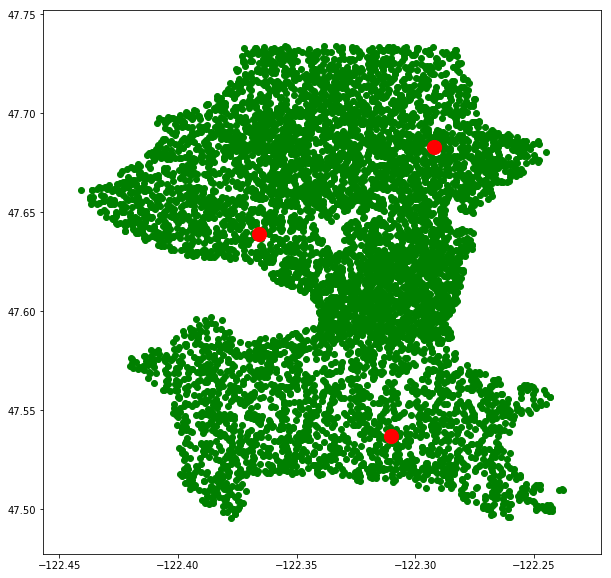

In [27]:
facility=pd.read_csv("fac.csv")
df = data.sort_values(by=['xcoord', 'ycoord'])
plt.figure(figsize=(10,10))
plt.scatter(df['xcoord'],df['ycoord'],color='g')
facInd=list(map(lambda x:x-1,list(map(int,FacilitiesRequired))))
depots=facility[facility.index.isin(facInd)]
plt.scatter(depots['xcoord'],depots['ycoord'], color='r',s=200)
plt.savefig("Optimal_Facilities.png")

In [28]:
facD=np.transpose(facD)
depotClusters=pd.DataFrame(facD)
depotClusters=depotClusters.iloc[:,facInd]
depotClusters.head()

,1,8,12
0,17.753797,7.982764,1.696474
1,20.364587,8.994785,5.598606
2,21.740472,11.682364,5.475101
3,18.381544,6.304994,8.308310
4,18.591356,8.505129,2.595009


In [29]:
# get the column name of min values in every row
minValueIndexObj = depotClusters.idxmin(axis=1)
depotClusters['Depot with Minimum Distance']=minValueIndexObj
depotClusters.head()

,1,8,12,Depot with Minimum Distance
0,17.753797,7.982764,1.696474,12
1,20.364587,8.994785,5.598606,12
2,21.740472,11.682364,5.475101,12
3,18.381544,6.304994,8.308310,8
4,18.591356,8.505129,2.595009,12


In [30]:
depotClusters.columns=list(map(str,depotClusters.columns))

In [31]:
facInd=list(map(str,facInd))
for f in facInd:
    depotNum=depotClusters[depotClusters['Depot with Minimum Distance']==int(f)]
    ind=depotNum['Depot with Minimum Distance'].unique
    #depotNum=depotNum[str(f)]
    

In [32]:
    n=len(depotNum)
    N=[i for i in range(1,n+1)]
    V=[0]+N
    A=[(i,j) for i in V for j in V]
    c= 

SyntaxError: invalid syntax (<ipython-input-32-fae367f015d1>, line 5)